# 🌡️ Electric Motor Temperature

In [2]:
#connect to google drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
#connect to kaggle
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#download the dataset
!kaggle datasets download -d wkirgsn/electric-motor-temperature

electric-motor-temperature.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#unzip dataset
!unzip electric-motor-temperature.zip

Archive:  electric-motor-temperature.zip
replace measures_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: measures_v2.csv         y



In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read data
data = pd.read_csv("/content/measures_v2.csv")

In [3]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


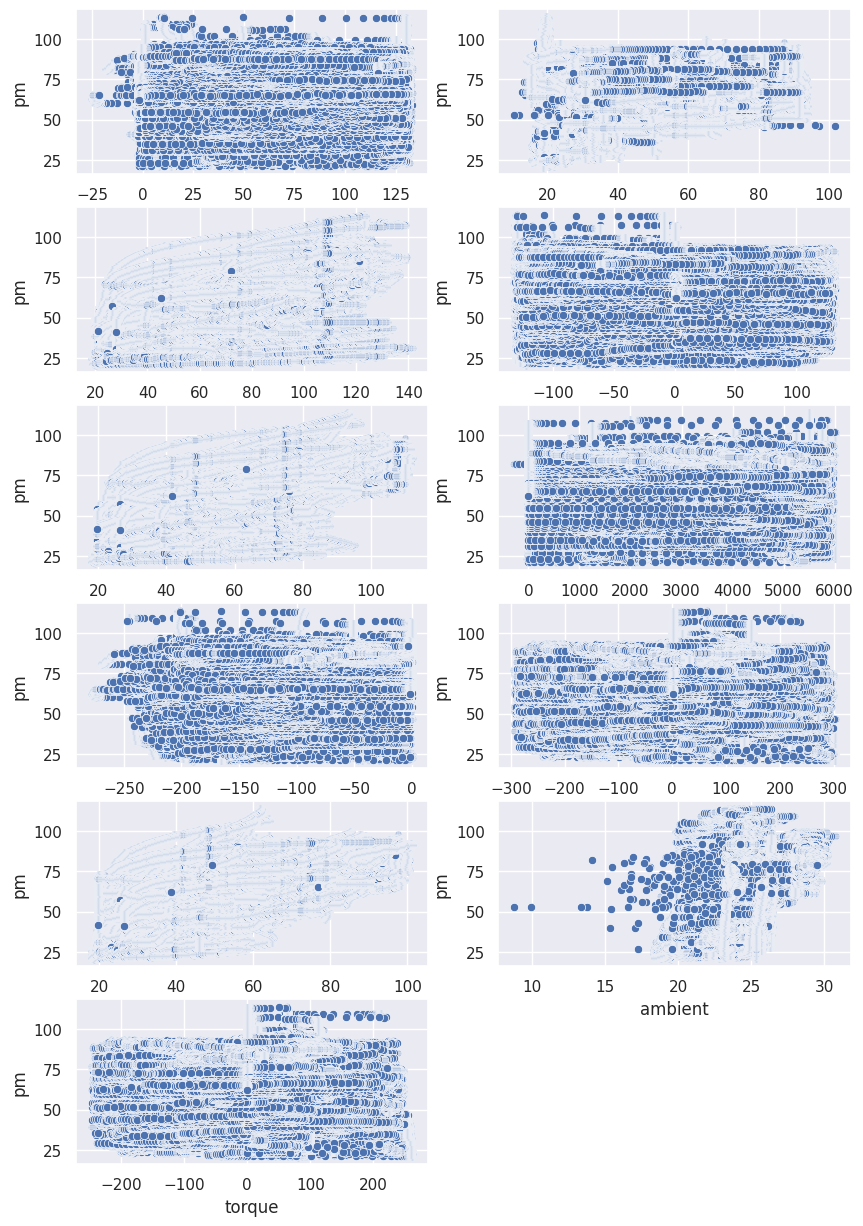

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, axes = plt.subplots(6, 2, figsize=(10, 15))

sns.scatterplot(data=data, x='u_q', y='pm', ax=axes[0, 0])
sns.scatterplot(data=data, x='coolant', y='pm', ax=axes[0, 1])
sns.scatterplot(data=data, x='stator_winding', y='pm', ax=axes[1, 0])
sns.scatterplot(data=data, x='u_d', y='pm', ax=axes[1, 1])
sns.scatterplot(data=data, x='stator_tooth', y='pm', ax=axes[2, 0])
sns.scatterplot(data=data, x='motor_speed', y='pm', ax=axes[2, 1])
sns.scatterplot(data=data, x='i_d', y='pm', ax=axes[3, 0])
sns.scatterplot(data=data, x='i_q', y='pm', ax=axes[3, 1])
sns.scatterplot(data=data, x='stator_yoke', y='pm', ax=axes[4, 0])
sns.scatterplot(data=data, x='ambient', y='pm', ax=axes[4, 1])
sns.scatterplot(data=data, x='torque', y='pm', ax=axes[5, 0])
fig.delaxes(axes[5, 1])

plt.show()

It is a bit difficult to observe a linear correlation of these columns with the target column (pm), although stator_winding, stator_tooth, and stator_yoke look interesting.

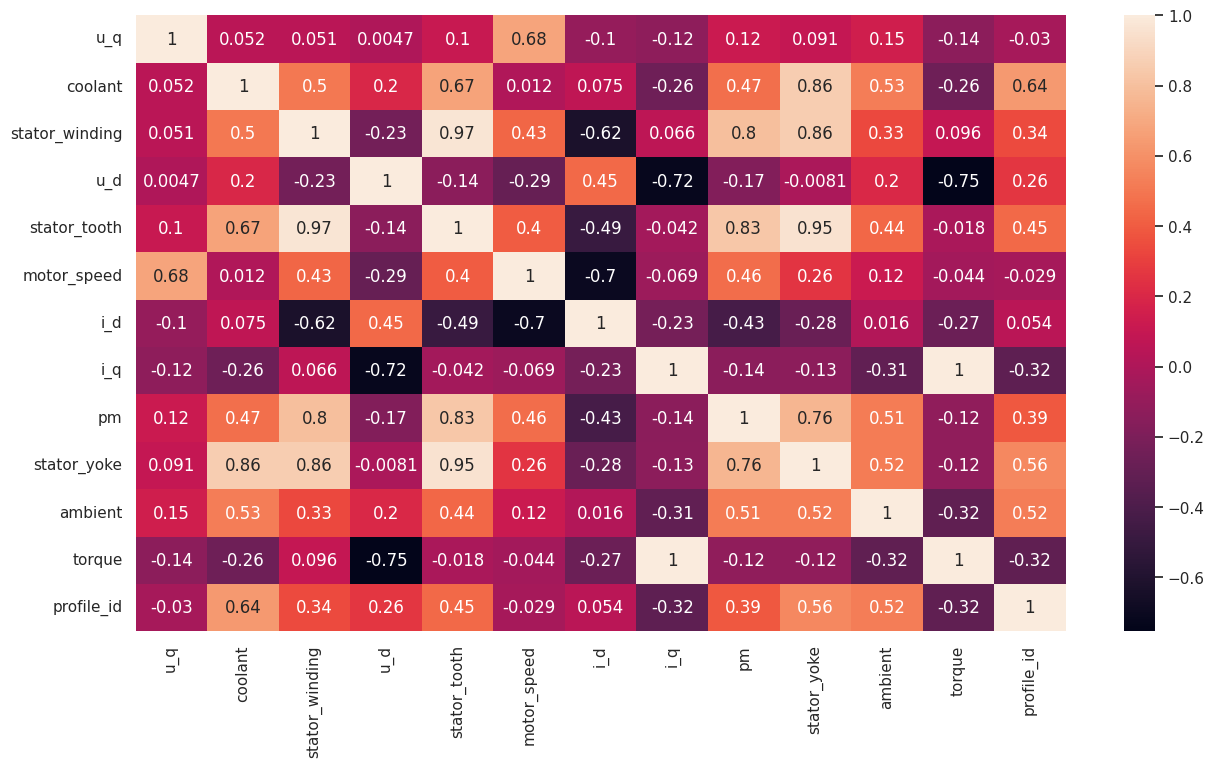

In [7]:
#plot heatmap
plt.figure(figsize=(15,8))
ax = sns.heatmap(data.corr(), annot=True)

Highest correlation with the target (pm): stator_winding, stator_tooth, stator_yoke, ambient.

Stator winding temperature, stator tooth temperature, stator yoke temperature, and ambient temperature have a high correlation with the permanent magnet temperature because they share physical proximity and heat sources in electric motors. The generated heat is commonly distributed among these components, and their thermal equilibrium, similar material properties, and overall motor design contribute to the observed correlation.

## Work with all columns

In [8]:
#split in X, y
X = data.drop(columns = 'pm', axis = 1)
y = data['pm']

In [9]:
#split in Test set and Train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
#predict using SKlearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))
print(mean_squared_error(y_pred, y_test))
print(mean_absolute_error(y_pred, y_test))

0.8560729082181513
51.96403463240374
5.38134405226076


In [13]:
#predict using SMLH
import math
class LinearRegression():
    def __init__(self):
        self.params__ = None
    def gradientDescent(self, X, y, learning_rate=0.00001, iterations=10, batch_size=16):
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        rows, cols = X.shape
        data = np.concatenate([X, y.values.reshape(-1, 1)], axis=1)
        w = np.random.random((cols, 1))

        for i in range(iterations):
            np.random.shuffle(data)
            y_it = data[:, -1].reshape((rows, 1))
            X_it = data[:, :-1]

            for batch in range(math.ceil(rows / batch_size)):
                batch_start = batch * batch_size
                x_batch = X_it[batch_start: min(batch_start + batch_size, X.shape[0])]
                y_batch = y_it[batch_start: min(batch_start + batch_size, X.shape[0])].reshape(-1, 1)

                w -= learning_rate * np.matmul(x_batch.transpose(), (np.matmul(x_batch, w) - y_batch))

        self.params__ = w
        return self

    def predict(self, X):
        X = np.concatenate([X, np.ones(X.shape[0]).reshape((X.shape[0], 1))], axis=1)
        return np.matmul(X, self.params__)

    def score(self, X, y):
        predictions = self.predict(X)
        y_mean = np.mean(y)
        ss_total = np.sum((y - y_mean) ** 2)
        ss_residual = np.sum((y - predictions) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

In [ ]:
#create an instance of the LinearRegression class and predict
model = LinearRegression()
model.gradientDescent(X_train, y_train)
predictions = model.predict(X_test)
#print(model.score(X_test, y_test))
print(mean_squared_error(y_pred, predictions))
print(mean_absolute_error(y_pred, predictions))

<ipython-input-13-57ea9b78c2a0>:22: RuntimeWarning: overflow encountered in matmul
  w -= learning_rate * np.matmul(x_batch.transpose(), (np.matmul(x_batch, w) - y_batch))
<ipython-input-13-57ea9b78c2a0>:22: RuntimeWarning: invalid value encountered in matmul
  w -= learning_rate * np.matmul(x_batch.transpose(), (np.matmul(x_batch, w) - y_batch))


##Work with selected columns

In [4]:
#data with absolute correlation between 0.5 and 0.8
new_data = data.copy()
new_data.drop(columns=["u_q", "coolant", "u_d", "stator_tooth", "motor_speed", "i_d", "i_q", "torque", "profile_id"], inplace=True)
print(new_data)

         stator_winding         pm  stator_yoke    ambient
0             19.086670  24.554214    18.316547  19.850691
1             19.092390  24.538078    18.314955  19.850672
2             19.089380  24.544693    18.326307  19.850657
3             19.083031  24.554018    18.330833  19.850647
4             19.082525  24.565397    18.326662  19.850639
...                 ...        ...          ...        ...
1330811       45.274497  62.147780    38.653720  23.989078
1330812       45.239017  62.142646    38.656328  23.970700
1330813       45.211576  62.138387    38.650923  23.977234
1330814       45.193508  62.133422    38.655686  24.001421
1330815       45.132307  62.131429    38.660370  24.027522

[1330816 rows x 4 columns]


In [5]:
#split in X, y
X = new_data.drop(columns = 'pm', axis = 1)
y = new_data['pm']

In [6]:
#split in Test set and Train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
#predict using SKlearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))
print(mean_squared_error(y_pred, y_test))
print(mean_absolute_error(y_pred, y_test))

0.7031126795569559
107.18943049865413
7.89976679536283


In [8]:
#predict using SMLH
import math
class LinearRegression():
    def __init__(self):
        self.params__ = None
    def gradientDescent(self, X, y, learning_rate=0.00001, iterations=100, batch_size=16):
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        rows, cols = X.shape
        data = np.concatenate([X, y.values.reshape(-1, 1)], axis=1)
        w = np.random.random((cols, 1))

        for i in range(iterations):
            np.random.shuffle(data)
            y_it = data[:, -1].reshape((rows, 1))
            X_it = data[:, :-1]

            for batch in range(math.ceil(rows / batch_size)):
                batch_start = batch * batch_size
                x_batch = X_it[batch_start: min(batch_start + batch_size, X.shape[0])]
                y_batch = y_it[batch_start: min(batch_start + batch_size, X.shape[0])].reshape(-1, 1)

                w -= learning_rate * np.matmul(x_batch.transpose(), (np.matmul(x_batch, w) - y_batch))

        self.params__ = w
        return self

    def predict(self, X):
        X = np.concatenate([X, np.ones(X.shape[0]).reshape((X.shape[0], 1))], axis=1)
        return np.matmul(X, self.params__)
    def score(self, X, y):
        predictions = self.predict(X)
        y_mean = np.mean(y)
        ss_total = np.sum((y - y_mean) ** 2)
        ss_residual = np.sum((y - predictions) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

In [9]:
#create an instance of the LinearRegression class and predict
model = LinearRegression()
model.gradientDescent(X_train, y_train)
predictions = model.predict(X_test)
#print(model.score(X_test, y_test))
print(mean_squared_error(y_pred, predictions))
print(mean_absolute_error(y_pred, predictions))

8.163760984931328
2.6198329676560284


# Conclusion:

In the first model, where all features were included, the logistic regression produced mean squared error (MSE) and mean absolute error (MAE) values of approximately 51.96 and 5.38, respectively. After refining the dataset by retaining only those columns with a correlation between 0.5 and 0.8 with the target column, the performance metrics increased to around 107.19 for MSE and 7.90 for MAE.

The observed increase in MSE and MAE when using a subset of features with higher correlation suggests that the initially excluded features may have contained valuable information for the model. It's possible that the omitted features, even though their correlation was not very strong, contributed to the model's predictive ability.

When applying a custom logistic regression model to the dataset with features limited to those exhibiting correlations between 0.5 and 0.8 with the target column, the model yielded improved performance metrics compared to the original logistic regression. Specifically, the mean squared error (MSE) decreased to approximately 8.16, and the mean absolute error (MAE) dropped to around 2.62.

This outcome suggests that the custom logistic regression model was more effective in capturing the underlying patterns within the selected features. The superior performance implies that the custom model was better suited to the nature of the relationships between features and the target variable.